In [ ]:
!nvidia-smi

Thu Jan 23 13:59:00 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [ ]:
framObjTrain = {'img': [],
                'mask': []
               }

def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=224):
    imgNames = os.listdir(imgPath)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for imgName in imgNames:
        # Check if the file is an image file
        if imgName.endswith('.png'):
            img = plt.imread(imgAddr + imgName)
            maskName = imgName.split('.png')[0] + '_mask.png'
            mask = plt.imread(maskAddr + maskName)

            img = cv2.resize(img, (shape, shape))
            mask = cv2.resize(mask, (shape, shape))

            frameObj['img'].append(img)
            frameObj['mask'].append(mask)

    return frameObj

In [ ]:
# loading benign samples

framObjTrain = LoadData( framObjTrain, imgPath = '/content/Seg/Images'
                        , maskPath = '/content/Seg/Masks'
                         , shape = 224)

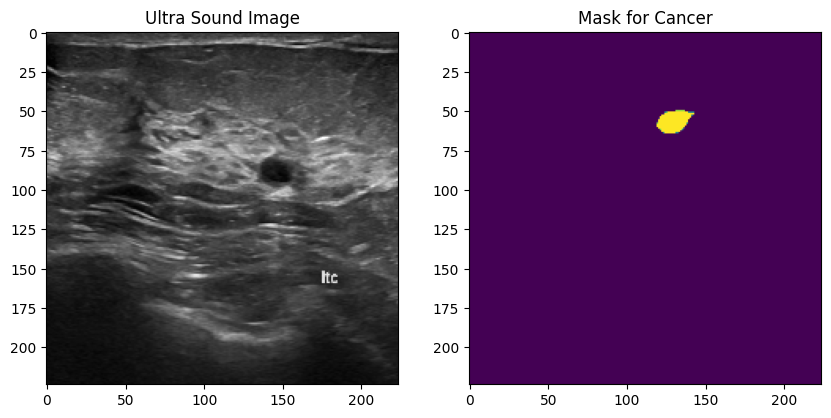

In [ ]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][0])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()

In [1]:
pip install superml

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(framObjTrain['img'], framObjTrain['mask'], test_size = 0.30, random_state = 42)

In [ ]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4) #8x8x128

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)


#decoder

    u6 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

# Model Instantiation

In [ ]:
batch_size = 128
inputs = tf.keras.layers.Input((224, 224, 3))
rkoshaheds_model = GiveMeUnet(inputs, droupouts= 0.3)
rkoshaheds_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
rkoshaheds_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 224, 224, 16)   │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 224, 224, 16)   │             64 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 224, 224, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 224, 224, 16)   │          2,320 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 224, 224, 16)   │             64 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 224, 224, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 112, 112, 16)   │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 112, 112, 16)   │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 112, 112, 32)   │          4,640 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 112, 112, 32)   │            128 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 112, 112, 32)   │          9,248 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 112, 112, 32)   │            128 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
│ (Activation)         

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
hisVal = rkoshaheds_model.fit(np.array(X_train), np.array(y_train), batch_size = batch_size, epochs = 100)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - accuracy: 0.4532 - loss: 0.8411
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4836 - loss: 0.7970
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5176 - loss: 0.7685
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5565 - loss: 0.7457
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5924 - loss: 0.7235
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6250 - loss: 0.6998
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6551 - loss: 0.6747
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6837 - loss: 0.6481
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7128 - loss: 0.6203
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7455 - loss: 0.5901
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7747 - loss: 0.5569
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.800

In [ ]:
retVal = rkoshaheds_model.fit(np.array(X_test), np.array(y_test), epochs = 100)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9974 - loss: 0.0446
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9974 - loss: 0.0442
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9978 - loss: 0.0434
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9977 - loss: 0.0433
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9978 - loss: 0.0430
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9980 - loss: 0.0428
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9978 - loss: 0.0429
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9978 - loss: 0.0426
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9982 - loss: 0.0418
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9979 - loss: 0.0420
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9977 - loss: 0.0420
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9976 - 

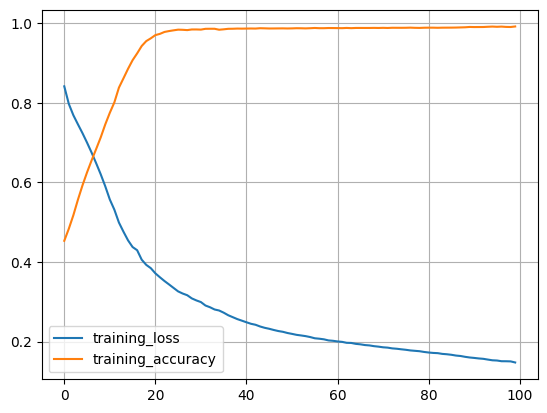

In [ ]:
plt.plot(hisVal.history['loss'], label = 'training_loss')
plt.plot(hisVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

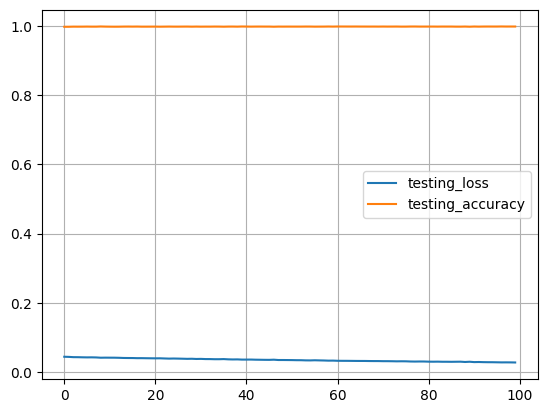

In [ ]:
plt.plot(retVal.history['loss'], label = 'testing_loss')
plt.plot(retVal.history['accuracy'], label = 'testing_accuracy')
plt.legend()
plt.grid(True)

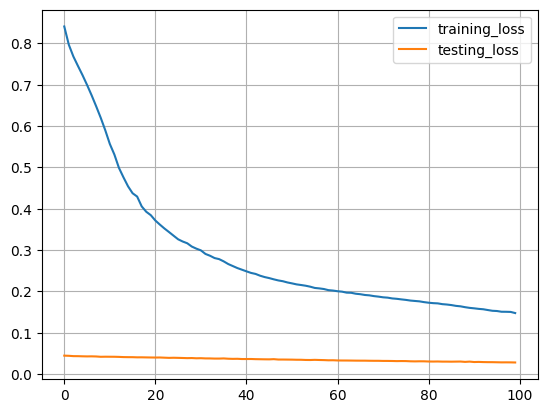

In [ ]:
plt.plot(hisVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['loss'], label = 'testing_loss')
plt.legend()
plt.grid(True)

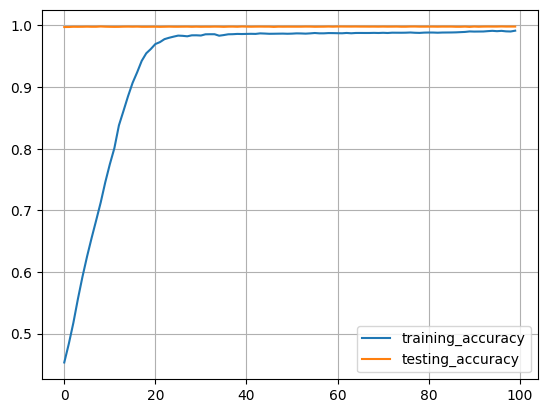

In [ ]:
plt.plot(hisVal.history['accuracy'], label = 'training_accuracy')
plt.plot(retVal.history['accuracy'], label = 'testing_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
#Testing
def predict16 (valMap, model, shape = 224):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)


    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


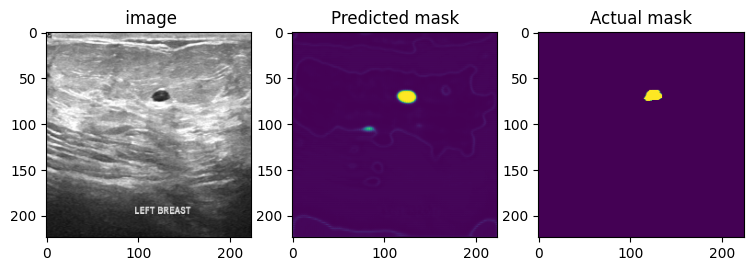

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, rkoshaheds_model)
Plotter(actuals[11], sixteenPrediction[11][:,:,0], masks[11])

In [ ]:
cv2.imwrite(r'test3.png',sixteenPrediction[1][:,:,0])

True

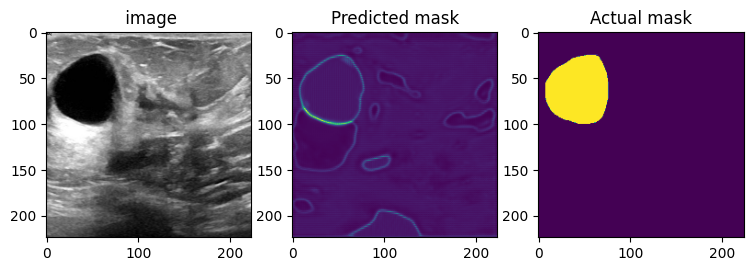

In [ ]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

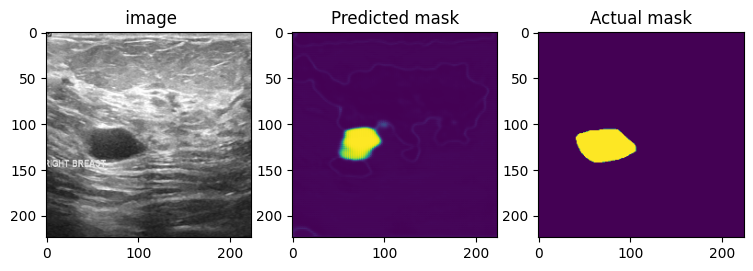

In [ ]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

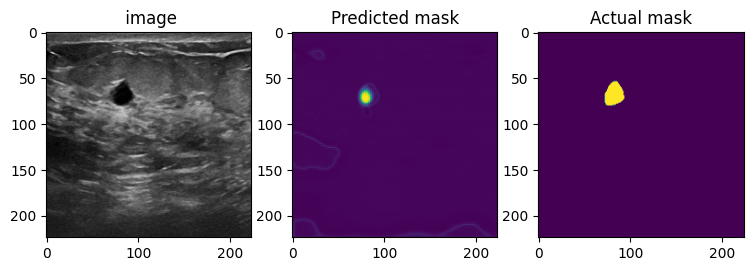

In [ ]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

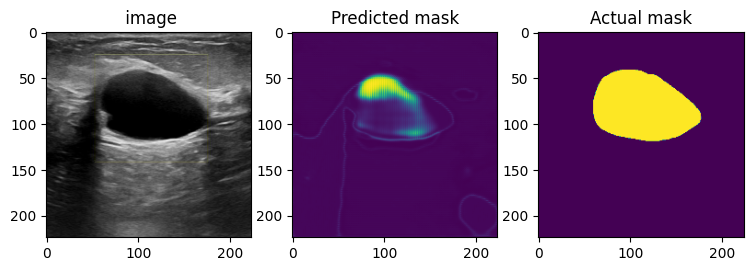

In [ ]:
Plotter(actuals[8], sixteenPrediction[8][:,:,0], masks[8])

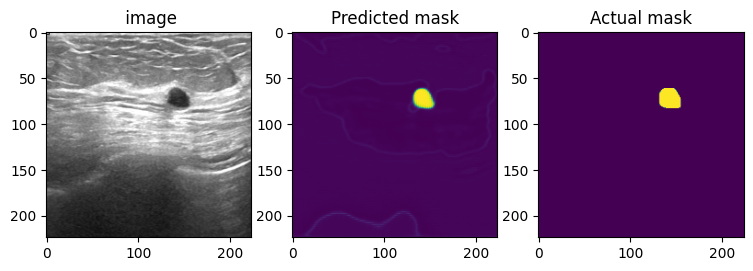

In [ ]:
Plotter(actuals[9], sixteenPrediction[9][:,:,0], masks[9])

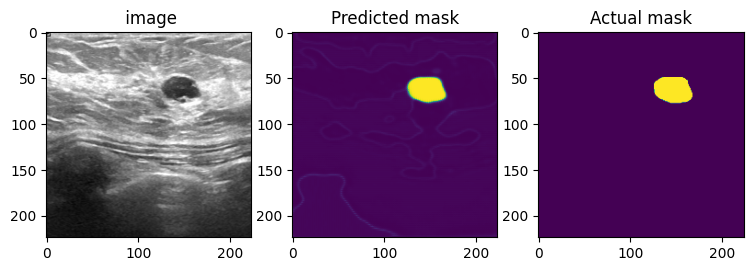

In [ ]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

In [ ]:
#Saving Model
rkoshaheds_model.save('New BreastCancerSegmentor.h5')